In [1]:
from imutils import paths
import imutils
import cv2
import numpy as np

In [2]:
#class 
class utils:
    def loadImages(path,resize):
        '''Load Images from path to array, @param path is the folder which containing images, @param resize is True
        if image is halved in size, otherwise is False'''
        image_path = list(paths.list_images(path))
        list_image = []
        for i,j in enumerate(image_path):
            image = cv2.imread(j)
            if resize==1:
                image=cv2.resize(image,(int(image.shape[1]/4),int(image.shape[0]/4)))
            list_image.append(image)
        return (list_image)

    def trim(frame):
        '''crop frame '''
        #crop top
        if not np.sum(frame[0]):
            return trim(frame[1:])
        #crop bottom
        elif not np.sum(frame[-1]):
            return trim(frame[:-2])
        #crop left
        elif not np.sum(frame[:,0]):
            return trim(frame[:,1:]) 
        #crop right
        elif not np.sum(frame[:,-1]):
            return trim(frame[:,:-2])    
        return frame

    def padding(img,top,bottom,left,right):
        '''add padding to img'''
        border = cv2.copyMakeBorder(
            img,
            top=top,
            bottom=bottom,
            left=left,
            right=right,
            borderType=cv2.BORDER_CONSTANT
        )
        return border

In [3]:
class features:
    def findAndDescribeFeatures(image,opt='ORB'):
        '''find and describe features of @image,
        if opt='SURF', SURF algorithm is used.
        if opt='SIFT', SIFT algorithm is used.
        if opt='ORB', ORB algorithm is used.
        @Return keypoints and features of img'''
        #Getting gray image
        grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if opt=='SURF':
            md = cv2.xfeatures2d.SURF_create()
        if opt=='ORB':
            md = cv2.ORB_create(nfeatures=3000)
        if opt=='SIFT':
            md = cv2.xfeatures2d.SIFT_create()
        #Find interest points and Computing features.
        keypoints, features = md.detectAndCompute(grayImage, None)
        #Converting keypoints to numbers.
        #keypoints = np.float32(keypoints)
        features = np.float32(features)
        return keypoints, features

    def matchFeatures(featuresA, featuresB,ratio=0.75,opt='FB'):
        '''matching features beetween 2 @features.
         If opt='FB', FlannBased algorithm is used.
         If opt='BF', BruteForce algorithm is used.
         @ratio is the Lowe's ratio test.
         @return matches'''
        if opt=='BF':
            featureMatcher = cv2.DescriptorMatcher_create("BruteForce")
        if opt=='FB':
            #featureMatcher = cv2.DescriptorMatcher_create("FlannBased")
            FLANN_INDEX_KDTREE = 0
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks = 50)
            featureMatcher = cv2.FlannBasedMatcher(index_params, search_params)


        #performs k-NN matching between the two feature vector sets using k=2 
        #(indicating the top two matches for each feature vector are returned).
        matches = featureMatcher.knnMatch(featuresA,featuresB, k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance<ratio*n.distance:
                good.append(m)
        if len(good)>4:
            return good
        else:
            raise Exception("Not enought matches") 

    def generateHomography(src_img, dst_img, ransacRep=5.0):
        '''@Return Homography matrix, @param src_img is the image which is warped by homography,
        @param dst_img is the image which is choosing as pivot, @param ratio is the David Lowe’s ratio,
        @param ransacRep is the maximum pixel “wiggle room” allowed by the RANSAC algorithm
        '''

        src_kp,src_features=features.findAndDescribeFeatures(src_img)
        dst_kp,dst_features=features.findAndDescribeFeatures(dst_img)

        good=features.matchFeatures(src_features,dst_features)

        src_points = np.float32([src_kp[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_points = np.float32([dst_kp[m.trainIdx].pt for m in good]).reshape(-1,1,2)

        H, mask  = cv2.findHomography(src_points, dst_points, cv2.RANSAC,ransacRep)
        matchesMask = mask.ravel().tolist()
        return H,matchesMask


    def drawKeypoints(img,kp):
        img1=img
        cv2.drawKeypoints(img,kp,img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        return img1

    def drawMatches(src_img,src_kp,dst_img,dst_kp,matches,matchesMask):
        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask[:100], # draw only inliers
                       flags = 2)
        return cv2.drawMatches(src_img,src_kp,dst_img,dst_kp,matches[:],None,**draw_params)

In [4]:
class stitch:
    def blendingMask(height, width, barrier, smoothing_window, left_biased=True):
        assert barrier < width
        mask = np.zeros((height, width))

        offset = int(smoothing_window/2)
        try:
            if left_biased:
                mask[:,barrier-offset:barrier+offset+1]=np.tile(np.linspace(1,0,2*offset+1).T, (height, 1))
                mask[:,:barrier-offset] = 1
            else:
                mask[:,barrier-offset:barrier+offset+1]=np.tile(np.linspace(0,1,2*offset+1).T, (height, 1))
                mask[:,barrier+offset:] = 1
        except:
            if left_biased:
                mask[:,barrier-offset:barrier+offset+1]=np.tile(np.linspace(1,0,2*offset).T, (height, 1))
                mask[:,:barrier-offset] = 1
            else:
                mask[:,barrier-offset:barrier+offset+1]=np.tile(np.linspace(0,1,2*offset).T, (height, 1))
                mask[:,barrier+offset:] = 1

        return cv2.merge([mask, mask, mask])

    def panoramaBlending(dst_img_rz,src_img_warped,width_dst,side,showstep=False):
        '''Given two aligned images @dst_img and @src_img_warped, and the @width_dst is width of dst_img 
        before resize, that indicates where there is the discontinuity between the images, 
        this function produce a smoothed transient in the overlapping.
        @smoothing_window is a parameter that determines the width of the transient
        left_biased is a flag that determines whether it is masked the left image,
        or the right one'''

        h,w,_=dst_img_rz.shape
        smoothing_window=int(width_dst/8)
        barrier = width_dst -int(smoothing_window/2)
        mask1 = stitch.blendingMask(h, w, barrier, smoothing_window = smoothing_window, left_biased = True)
        mask2 = stitch.blendingMask(h, w, barrier, smoothing_window = smoothing_window, left_biased = False)

        if showstep:
            nonblend=src_img_warped+dst_img_rz
        else:
            nonblend=None
            leftside=None
            rightside=None

        if side=='left':
            dst_img_rz=cv2.flip(dst_img_rz,1)
            src_img_warped=cv2.flip(src_img_warped,1)
            dst_img_rz=(dst_img_rz*mask1)
            src_img_warped=(src_img_warped*mask2)
            pano=src_img_warped+dst_img_rz
            pano=cv2.flip(pano,1)
            if showstep:
                leftside=cv2.flip(src_img_warped,1)
                rightside=cv2.flip(dst_img_rz,1)
        else:
            dst_img_rz=(dst_img_rz*mask1)
            src_img_warped=(src_img_warped*mask2)
            pano=src_img_warped+dst_img_rz
            if showstep:
                leftside=dst_img_rz
                rightside=src_img_warped


        return pano,nonblend,leftside,rightside

    def warpTwoImages(src_img, dst_img,showstep=False):

        #generate Homography matrix
        H,_=features.generateHomography(src_img,dst_img)

        #get height and width of two images
        height_src,width_src = src_img.shape[:2]
        height_dst,width_dst = dst_img.shape[:2]

        #extract conners of two images: top-left, bottom-left, bottom-right, top-right
        pts1 = np.float32([[0,0],[0,height_src],[width_src,height_src],[width_src,0]]).reshape(-1,1,2)
        pts2 = np.float32([[0,0],[0,height_dst],[width_dst,height_dst],[width_dst,0]]).reshape(-1,1,2)

        try:
            #aply homography to conners of src_img
            pts1_ = cv2.perspectiveTransform(pts1, H)
            pts = np.concatenate((pts1_, pts2), axis=0)

            #find max min of x,y coordinate
            [xmin, ymin] = np.int64(pts.min(axis=0).ravel() - 0.5)
            [xmax, ymax] = np.int64(pts.max(axis=0).ravel() + 0.5)
            t = [-xmin,-ymin]


            #top left point of image which apply homography matrix, which has x coordinate < 0, has side=left
            #otherwise side=right
            #source image is merged to the left side or right side of destination image
            if(pts[0][0][0]<0):
                side='left'
                width_pano=width_dst+t[0]
            else:
                width_pano=int(pts1_[3][0][0])
                side='right'
            height_pano=ymax-ymin

            #Translation 
            #https://stackoverflow.com/a/20355545
            Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) 
            src_img_warped = cv2.warpPerspective(src_img, Ht.dot(H), (width_pano,height_pano))
            #generating size of dst_img_rz which has the same size as src_img_warped
            dst_img_rz=np.zeros((height_pano,width_pano,3))
            if side=='left':
                dst_img_rz[t[1]:height_src+t[1],t[0]:width_dst+t[0]] = dst_img
            else:
                dst_img_rz[t[1]:height_src+t[1],:width_dst] = dst_img

            #blending panorama
            pano,nonblend,leftside,rightside=stitch.panoramaBlending(dst_img_rz,src_img_warped,width_dst,side,showstep=showstep)

            #croping black region
            pano=stitch.crop(pano,height_dst,pts)
            return pano,nonblend,leftside,rightside
        except:
            raise Exception("Please try again with another image set!")

    def multiStitching(list_images):
        '''assume that the list_images was supplied in left-to-right order, choose middle image then 
        divide the array into 2 sub-arrays, left-array and right-array. Stiching middle image with each
        image in 2 sub-arrays. @param list_images is The list which containing images, @param smoothing_window is 
        the value of smoothy side after stitched, @param output is the folder which containing stitched image
        '''
        n=int(len(list_images)/2+0.5)
        left=list_images[:n]
        right=list_images[n-1:]
        right.reverse()
        while len(left)>1:
            dst_img=left.pop()
            src_img=left.pop()
            left_pano,_,_,_=stitch.warpTwoImages(src_img,dst_img)
            left_pano=left_pano.astype('uint8')
            left.append(left_pano)

        while len(right)>1:
            dst_img=right.pop()
            src_img=right.pop()
            right_pano,_,_,_=stitch.warpTwoImages(src_img,dst_img)
            right_pano=right_pano.astype('uint8')
            right.append(right_pano)

        #if width_right_pano > width_left_pano, Select right_pano as destination. Otherwise is left_pano
        if(right_pano.shape[1]>=left_pano.shape[1]):
            fullpano,_,_,_=stitch.warpTwoImages(left_pano,right_pano)
        else:
            fullpano,_,_,_=stitch.warpTwoImages(right_pano,left_pano)
        return fullpano

    def crop(panorama,h_dst,conners):
        '''crop panorama based on destination.
        @param panorama is the panorama
        @param h_dst is the hight of destination image
        @param conner is the tuple which containing 4 conners of warped image and 
        4 conners of destination image'''
        #find max min of x,y coordinate
        [xmin, ymin] = np.int32(conners.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(conners.max(axis=0).ravel() + 0.5)
        t = [-xmin,-ymin]
        conners=conners.astype(int)

        #conners[0][0][0] is the X coordinate of top-left point of warped image
        #If it has value<0, warp image is merged to the left side of destination image
        #otherwise is merged to the right side of destination image
        if conners[0][0][0]<0:
            n=abs(-conners[1][0][0]+conners[0][0][0])
            panorama=panorama[t[1]:h_dst+t[1],n:,:]
        else:
            if(conners[2][0][0]<conners[3][0][0]):
                panorama=panorama[t[1]:h_dst+t[1],0:conners[2][0][0],:]
            else:
                panorama=panorama[t[1]:h_dst+t[1],0:conners[3][0][0],:]
        return panorama

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
def convertResult(img):
    '''Because of our images which were loaded by opencv, 
    in order to display the correct output with matplotlib, 
    you need to reduce the range of your floating point image from [0,255] to [0,1] 
    and converting the image from BGR to RGB:'''
    img = np.array(img,dtype=float)/float(255)
    img = img[:,:,::-1]
    return img

In [7]:
# printing the names of the images 
import os
list = os.listdir('parrington/parrington_dataset')
for i in range(len(list)):
  print(list[i])

prtn00.jpg
prtn01.jpg
prtn02.jpg
prtn03.jpg


In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [9]:
image_1 = mpimg.imread("parrington/parrington_dataset/prtn00.jpg")
image_2 = mpimg.imread("parrington/parrington_dataset/prtn01.jpg")
image_3 = mpimg.imread("parrington/parrington_dataset/prtn02.jpg")
image_4 = mpimg.imread("parrington/parrington_dataset/prtn03.jpg")

In [10]:
image_1_opcv = cv2.imread("UTS_FILE/Nomer3/Bengkok1.jpg")
image_2_opcv = cv2.imread("UTS_FILE/Nomer3/Bengkok2.jpg")
image_3_opcv = cv2.imread("UTS_FILE/Nomer3/Bengkok3.jpg")
# image_4_opcv = cv2.imread("Kelas4.jpg")

In [11]:
list_images_opcv = [image_1_opcv, image_2_opcv, image_3_opcv]

In [12]:
for iam in list_images_opcv:
    print(iam.flags)
    print(type(iam))

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

<class 'numpy.ndarray'>
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

<class 'numpy.ndarray'>
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

<class 'numpy.ndarray'>


In [13]:
#load images
# list_images= [image_1,image_2,image_3,image_4]
list_images = [image_1_opcv, image_2_opcv, image_3_opcv]

In [14]:
for images_after_res in list_images:
    print(images_after_res.shape)

(897, 1600, 3)
(897, 1600, 3)
(897, 1600, 3)


In [15]:
for images in list_images:
    print(images.flags)
    images.setflags(write=True)
    print(images.flags)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



In [16]:
for image in list_images:
    print(image)
    print(type(image))

[[[134 139 142]
  [134 139 142]
  [134 139 142]
  ...
  [138 144 149]
  [140 146 151]
  [143 149 154]]

 [[134 139 142]
  [134 139 142]
  [134 139 142]
  ...
  [141 147 152]
  [144 150 155]
  [146 152 157]]

 [[134 139 142]
  [134 139 142]
  [134 139 142]
  ...
  [146 152 157]
  [148 154 159]
  [151 157 162]]

 ...

 [[ 61  60  62]
  [ 64  63  65]
  [ 64  63  65]
  ...
  [113 116 120]
  [113 116 120]
  [113 116 120]]

 [[ 64  63  65]
  [ 65  64  66]
  [ 64  63  65]
  ...
  [112 115 119]
  [112 115 119]
  [112 115 119]]

 [[ 73  71  71]
  [ 69  67  67]
  [ 65  63  63]
  ...
  [113 114 118]
  [113 114 118]
  [113 114 118]]]
<class 'numpy.ndarray'>
[[[140 142 143]
  [140 142 143]
  [141 143 144]
  ...
  [148 150 150]
  [148 150 150]
  [148 150 150]]

 [[ 86  88  89]
  [ 86  88  89]
  [ 87  89  90]
  ...
  [148 150 150]
  [148 150 150]
  [148 150 150]]

 [[131 133 134]
  [131 133 134]
  [132 134 135]
  ...
  [148 150 150]
  [148 150 150]
  [148 150 150]]

 ...

 [[ 77  78  74]
  [ 78  79  

In [17]:
#extract keypoints and descriptors using sift
k0,f0=features.findAndDescribeFeatures(list_images[0])
k1,f1=features.findAndDescribeFeatures(list_images[1])

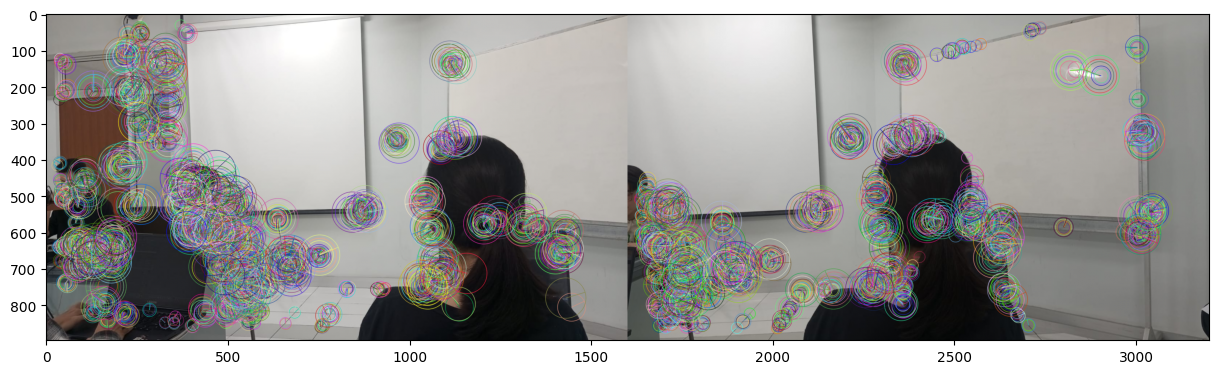

In [18]:
#draw keypoints
img0_kp=features.drawKeypoints(list_images[0],k0)
img1_kp=features.drawKeypoints(list_images[1],k1)

plt_img = np.concatenate((img0_kp, img1_kp), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(convertResult(plt_img))

In [19]:
mat=features.matchFeatures(f0,f1,ratio=0.85,opt='BF')

In [20]:
#Computing Homography matrix and mask
H,matMask=features.generateHomography(list_images[0],list_images[1])

In [21]:
#wrap 2 image
#choose list_images[0] as desination
pano,non_blend,left_side,right_side=stitch.warpTwoImages(list_images[0],list_images[1],True)

Exception: Please try again with another image set!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


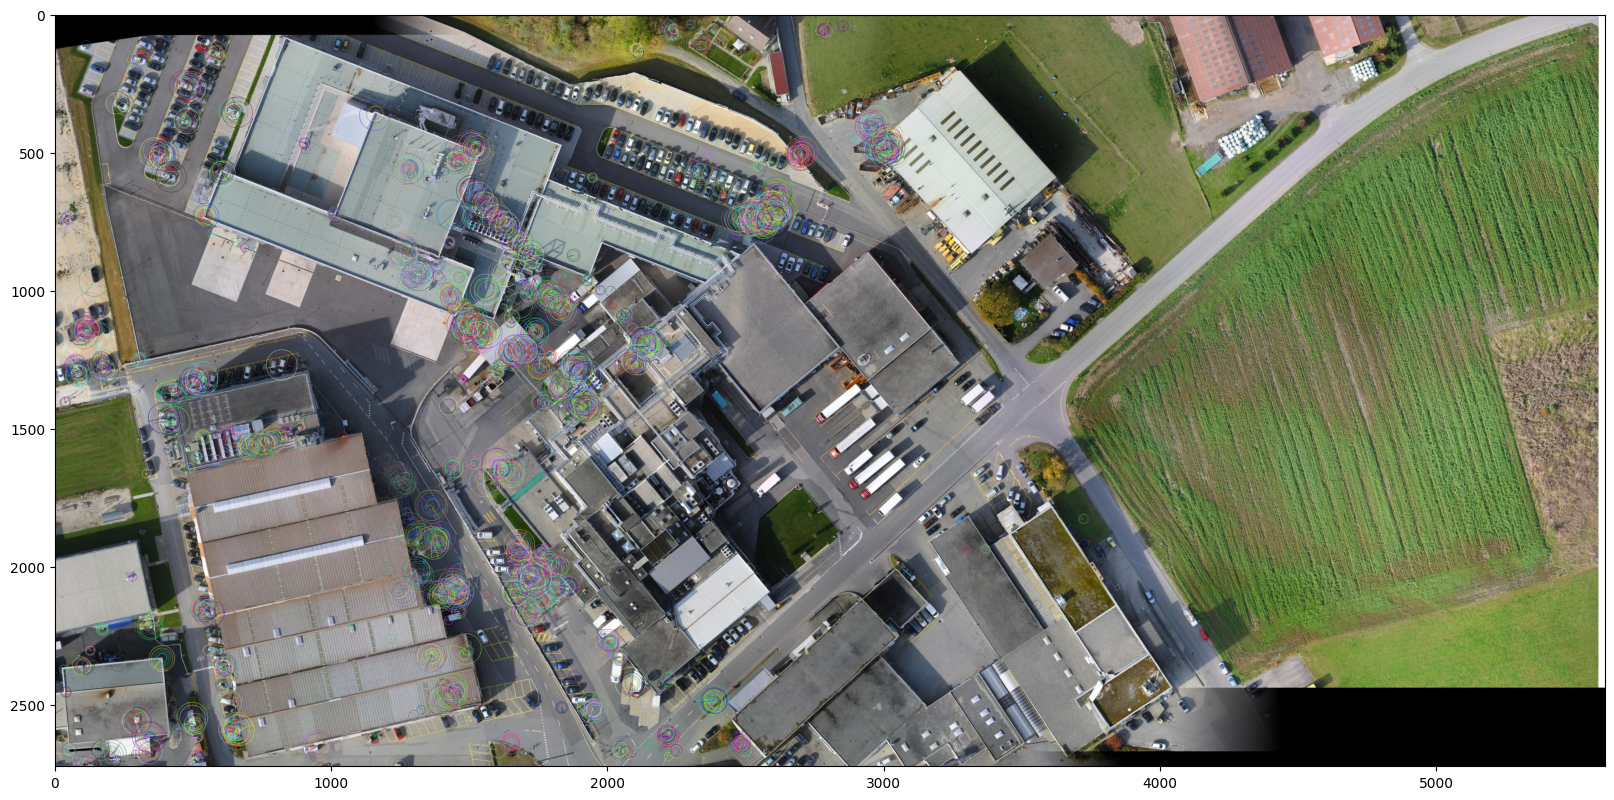

In [ ]:
panorama=stitch.multiStitching(list_images)
plt.figure(figsize=(20,20))
plt.imshow(convertResult(panorama))